# map demo 2

In this example we will 
- Look at `rnaturalearth`
- make a choropleth
- play with projection a bit more. 


Warning message:
“plotting the first 9 out of 83 attributes; use max.plot = 83 to plot all”


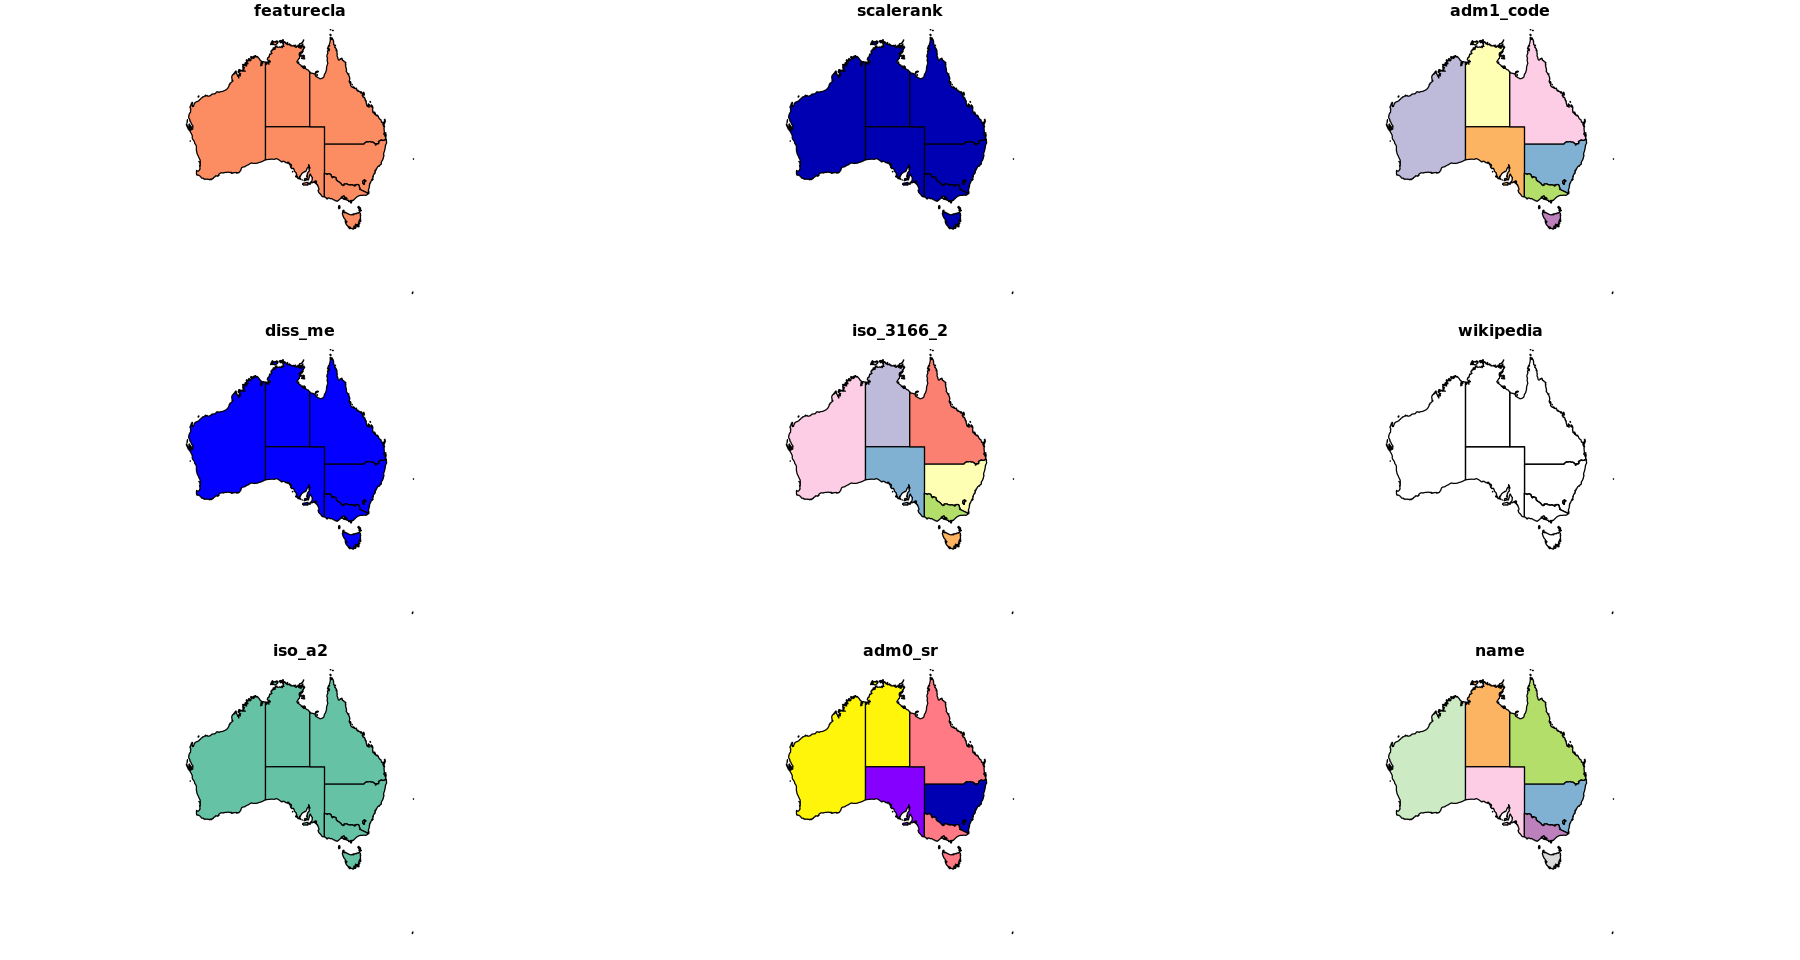

In [224]:
library("rnaturalearth")

# You also need to install rnaturalearthhires for this to work. 
# devtools::install_github("ropensci/rnaturalearthhires")
# devtools::install_github("ropensci/rnaturalearthdata")


au_sf <- ne_states(geounit = "australia",
                   returnclass = "sf")

plot(au_sf)

# Some example  data to show on our map 

states,pop_in_cap
<chr>,<dbl>
Australian Capital Territory,99.6
New South Wales,63.0
Northern Territory,54.0
Queensland,46.0
South Australia,73.5
Tasmania,41.0
Victoria,71.0
Western Australia,73.4


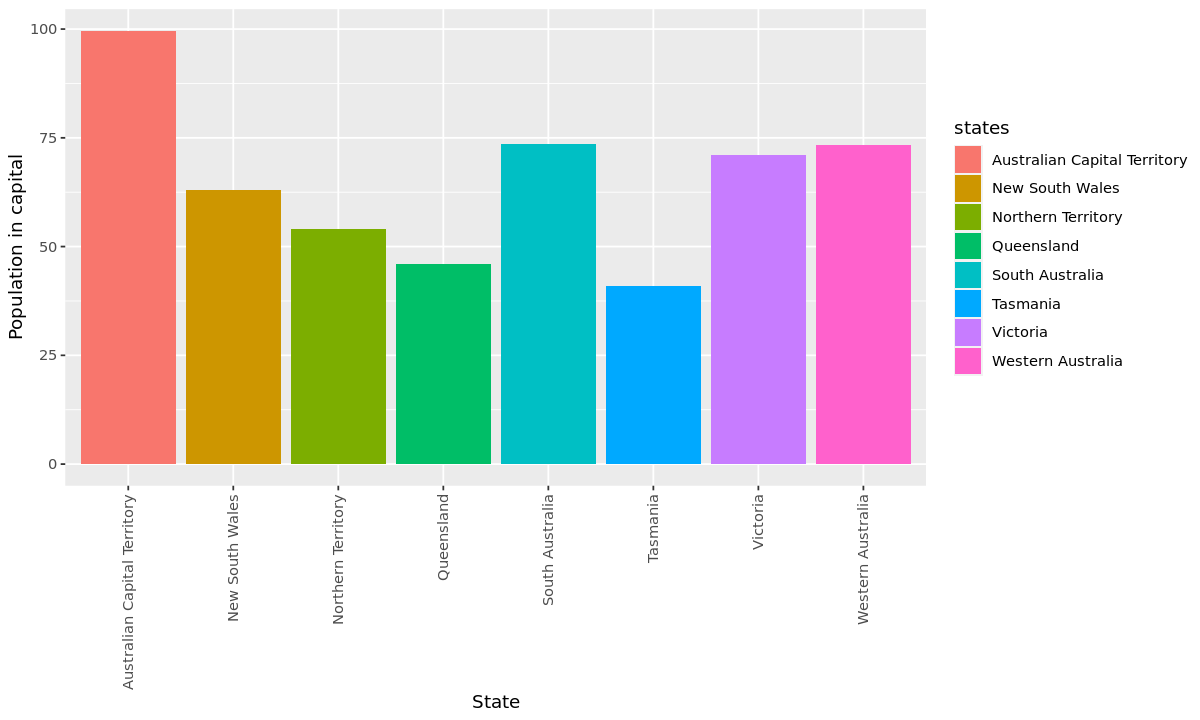

In [225]:
options(repr.plot.width=10, repr.plot.height=6)

states <- c("Australian Capital Territory" ,"New South Wales",
            "Northern Territory", "Queensland", "South Australia", "Tasmania",
            "Victoria", "Western Australia")
            
# I found some numbers for the percentage of people in each state who live in the capital 
# in Australia. If you didn't know, despite Australia being so big, most people live in 
# one of the major cities. 

pop_in_cap <- c(99.6, 63.0, 54.0, 46.0, 73.5, 41.0, 71.0, 73.4)
df <- data.frame(states, pop_in_cap)


df 

# Let's plot it just to see what we are working with. 
ggplot(data=df, aes(x=states, y=pop_in_cap, fill=states)) + 
    geom_bar(stat="identity") + 
    ylab("Population in capital") + 
    xlab("State") + 
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

# Chrolopeth map 

From Wiki:

> A choropleth map is a type of statistical thematic map that uses intensity of color to 
    correspond with an aggregate summary of a geographic characteristic within spatial enumeration units,
    such as population density or per-capita income.

So this is basically, a map + a heatmap. You would have seen these before. One of the ones I've been looking at a lot (because of Covid19) is the [lineage map from Sanger](https://covid19.sanger.ac.uk/lineages/raw)





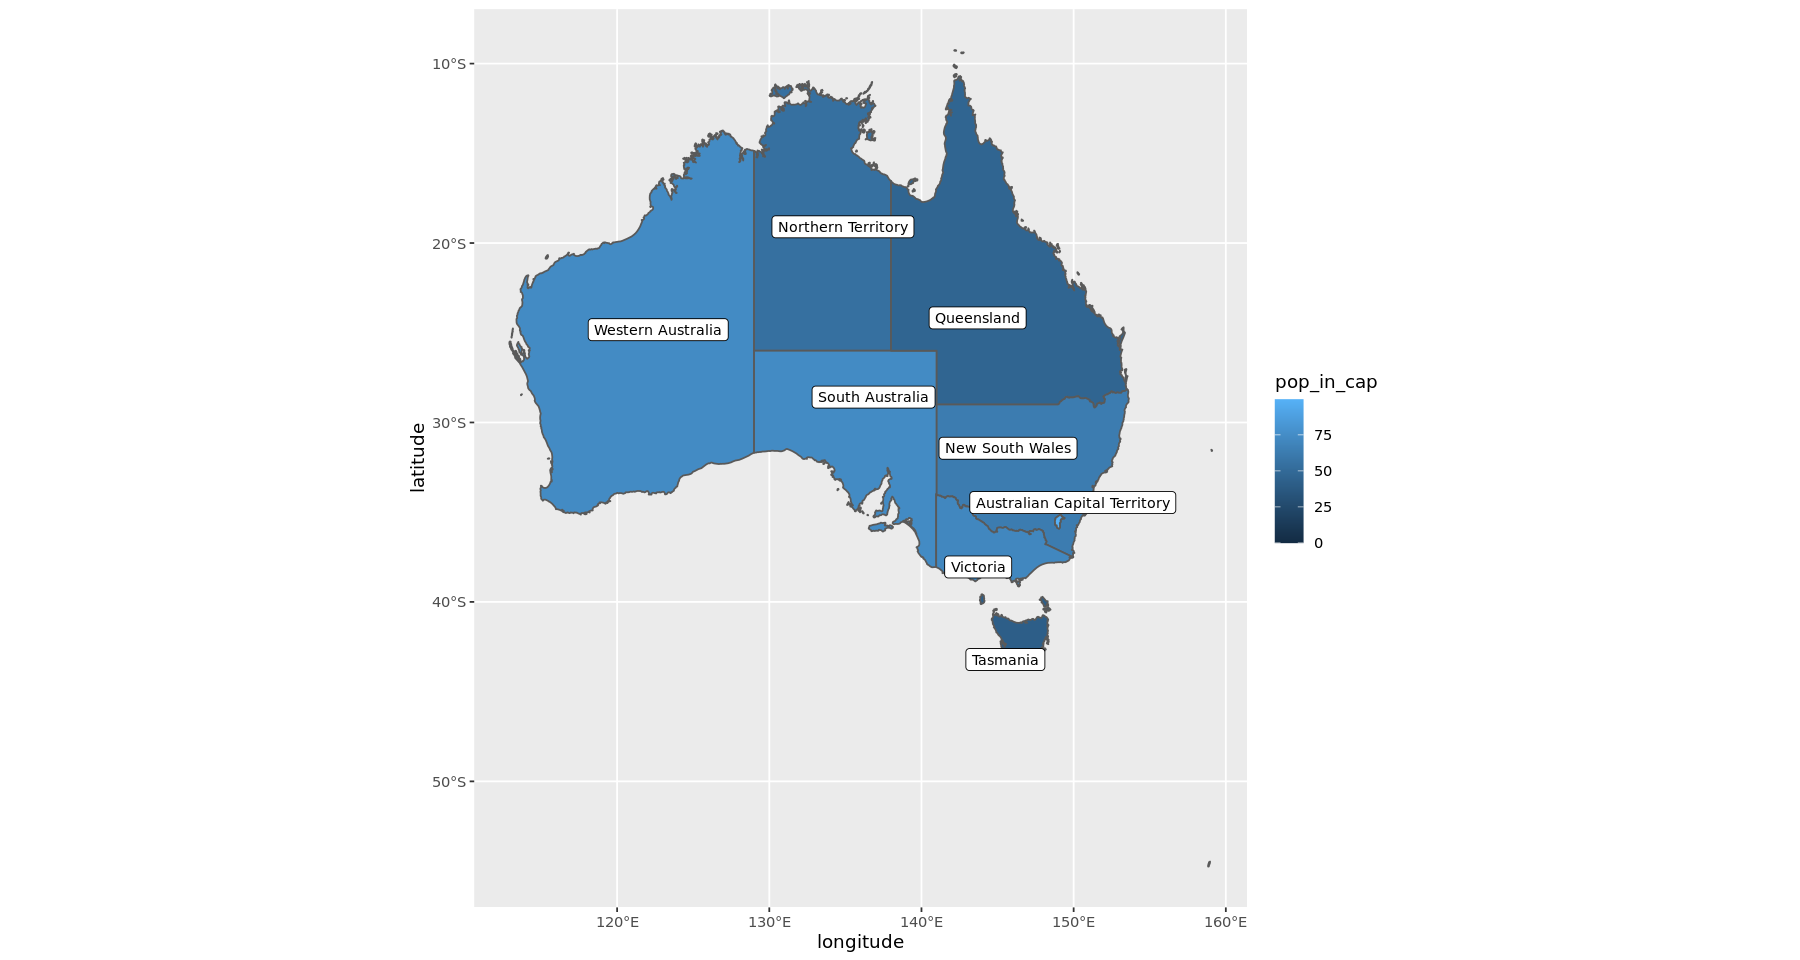

In [226]:
library("ggplot2")
library("rnaturalearth")
library("dplyr")
library(ggrepel)
library(sf)


options(repr.plot.width=15, repr.plot.height=8)
in_sf <- ne_states(geounit = "australia",
                   returnclass = "sf")

in_sf_label <- in_sf  %>% filter(name != "Lord Howe Island", name != "Macquarie Island", name != "Jervis Bay Territory")
# Let's ignore some small regions

in_sf <- in_sf %>% select(name) %>%
  left_join(. , df, by=c("name"="states"))

in_sf$pop_in_cap[ is.na(in_sf$pop_in_cap)] = 0


australia <- ggplot() +
    geom_sf(data = in_sf, aes(fill = pop_in_cap))  +
  geom_label_repel(data = in_sf_label, 
                   aes(x=longitude,y = latitude, label = name),
                   size = 3, force = 5, force_pull = 5) 
australia 


# Map projections in R

Previously we used the baked in map projections from `ggplot` using `coord_map()`. Now I will try to customise it as we like. 
Map projections are intensely complicated, and I frankly have no idea what I am doing. 

The trick here is that internally everything we are looking at is just a vector graphic and to add in something like a map projection we need to transform the shapes to fit that projection.  In the next few examples I will use `coord_sf()` to take our ggplots and transform them to show a projected map. 


## EPSG 

Rather than having to figure out all the settings yourself, people have created templates you can use. 
These have been picked to be the best compromise between showing something sensible while being true 
to the proportions of the different land masses. It is quite difficult to show something that is 
round - like the Earth - on a flat plane. 

The one I found to be useful is the EPSG

> The EPSG is a structured dataset of CRS and
Coordinate Transformations. It was originally compiled by
the, now defunct, European Petroleum Survey Group. Here
are some websites: https://epsg.io/ 
http://spatialreference.org/

There are different projections for different regions all over the world. There are many options
depending on which region you want to show, and the type of projection you would like to use. 

For Australia for instance, I found these to be common: 

- EPSG:3857 "WGS 84 (ensemble) / Pseudo-Mercator (Web Mercator)" Most common!
- EPSG:3577 "GDA94 / Australian Albers" (My favourite)  https://epsg.io/3577 
- EPSG:4203 "AGD84" https://epsg.io/4203-1236 
 
Let's see what the difference would be 







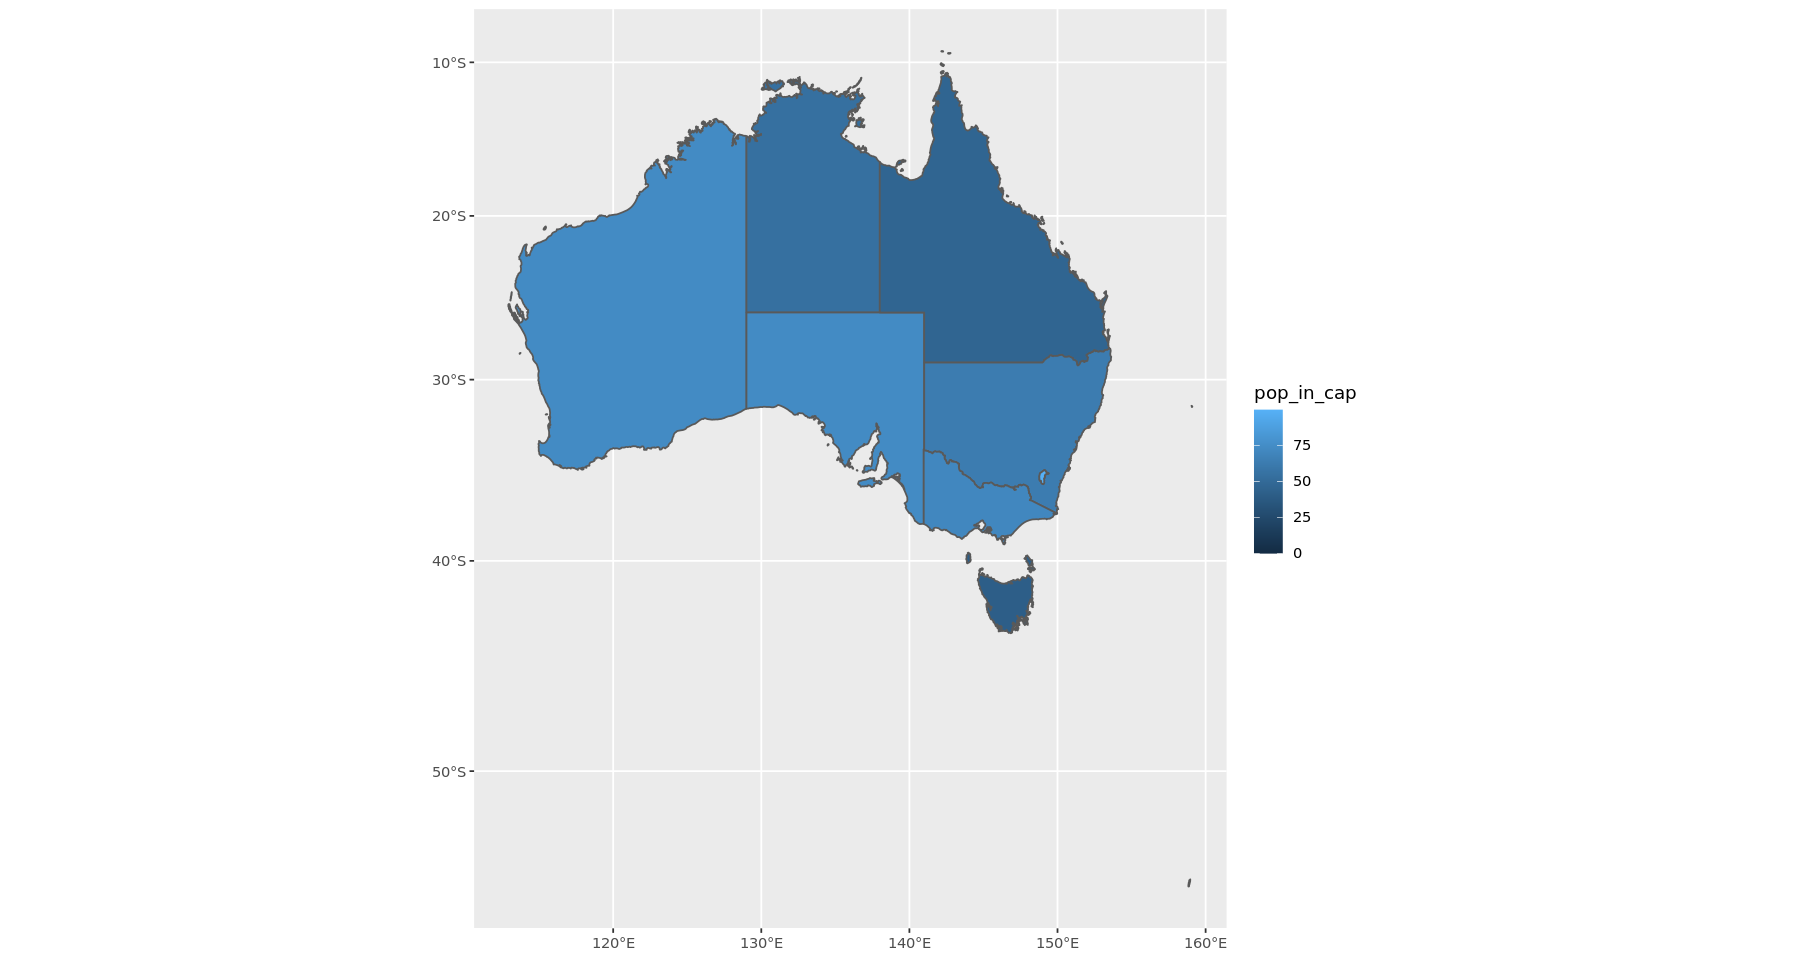

In [227]:
australia <-  ggplot() +
    geom_sf(data = in_sf, aes(fill = pop_in_cap)) +
    coord_sf(crs= 3857) # This is your standard Mercator (should look like google maps)
australia

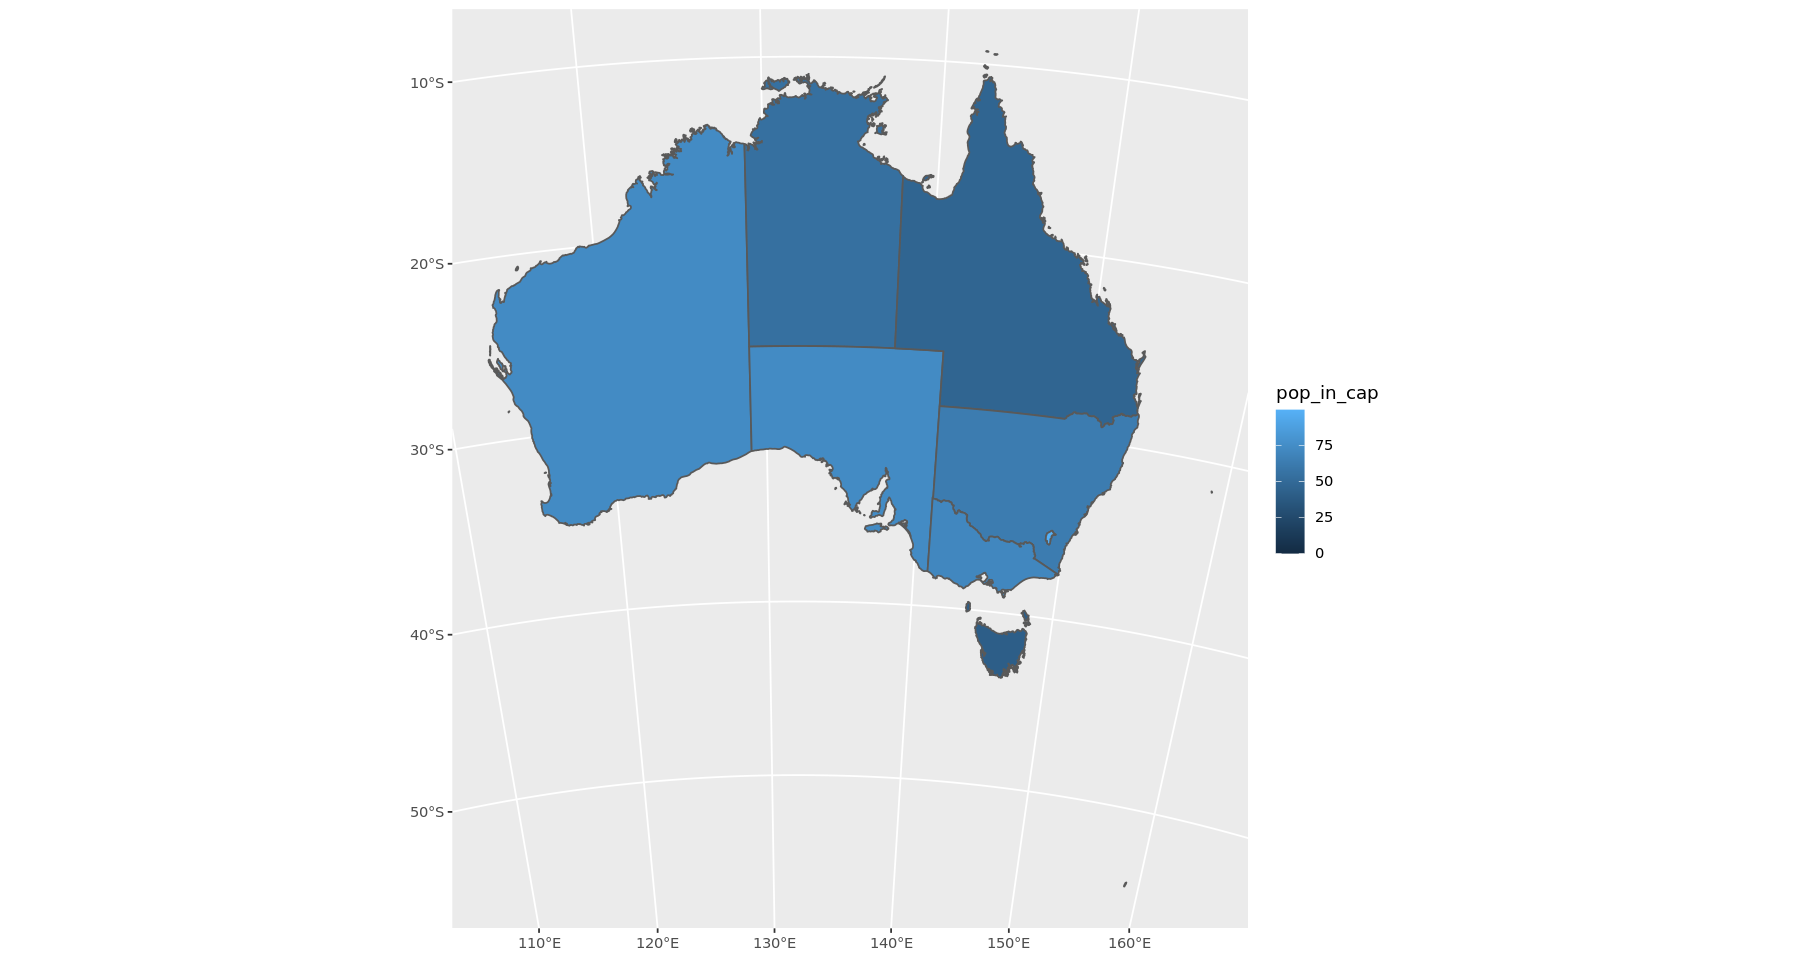

In [228]:
australia <-  ggplot() +
    geom_sf(data = in_sf, aes(fill = pop_in_cap)) +
    coord_sf(crs= 3577) 
# This is with a bit curvature, but you can still recognize 
# All the states, I like it. 
# Can you see the difference to the one above?
australia

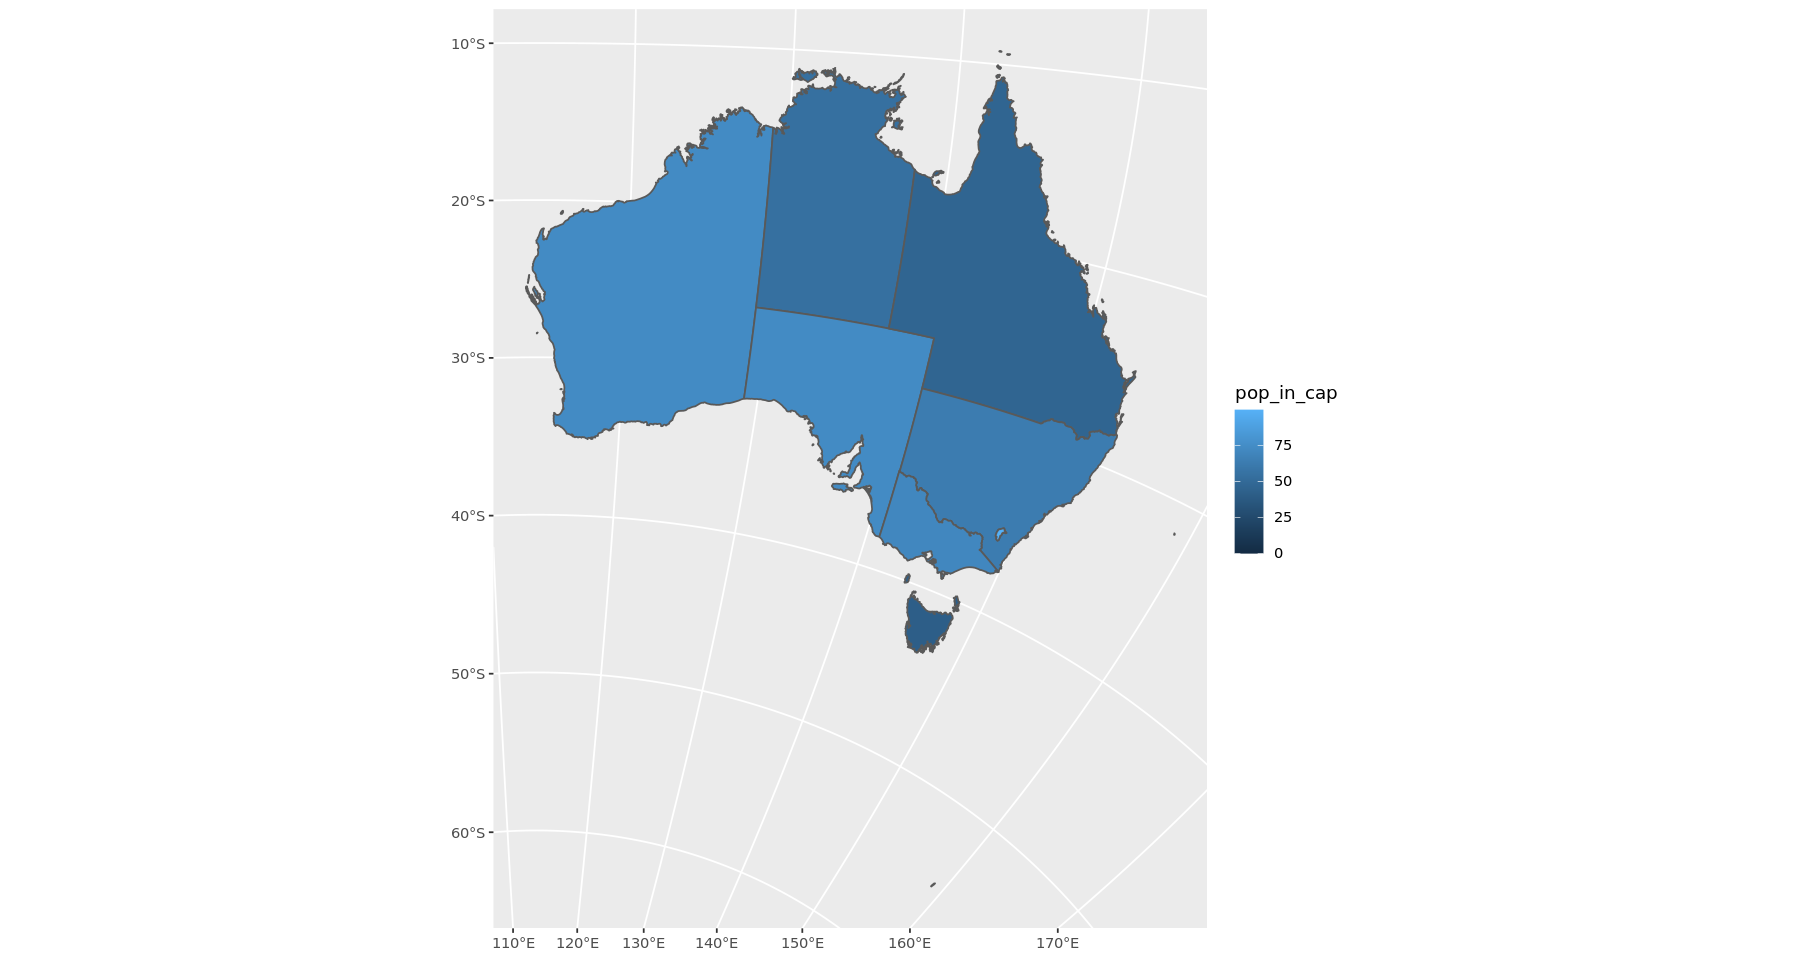

In [229]:
australia <-  ggplot() +
    geom_sf(data = in_sf, aes(fill = pop_in_cap)) +
    coord_sf(crs= 8017) 
# This one is supposed to be a "Geocentric translations (geog2D domain)"
# centering on Western Australia (right).
australia

# Custom settings and PROJ
You can fully customise the map and the projection using the "PROJ" strings. https://proj.org/index.html 

This is a deep rabbit hole though, and it can get weird. So I would recommend 
sticking to the standards above.

Warning message:
“ggrepel: 8 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


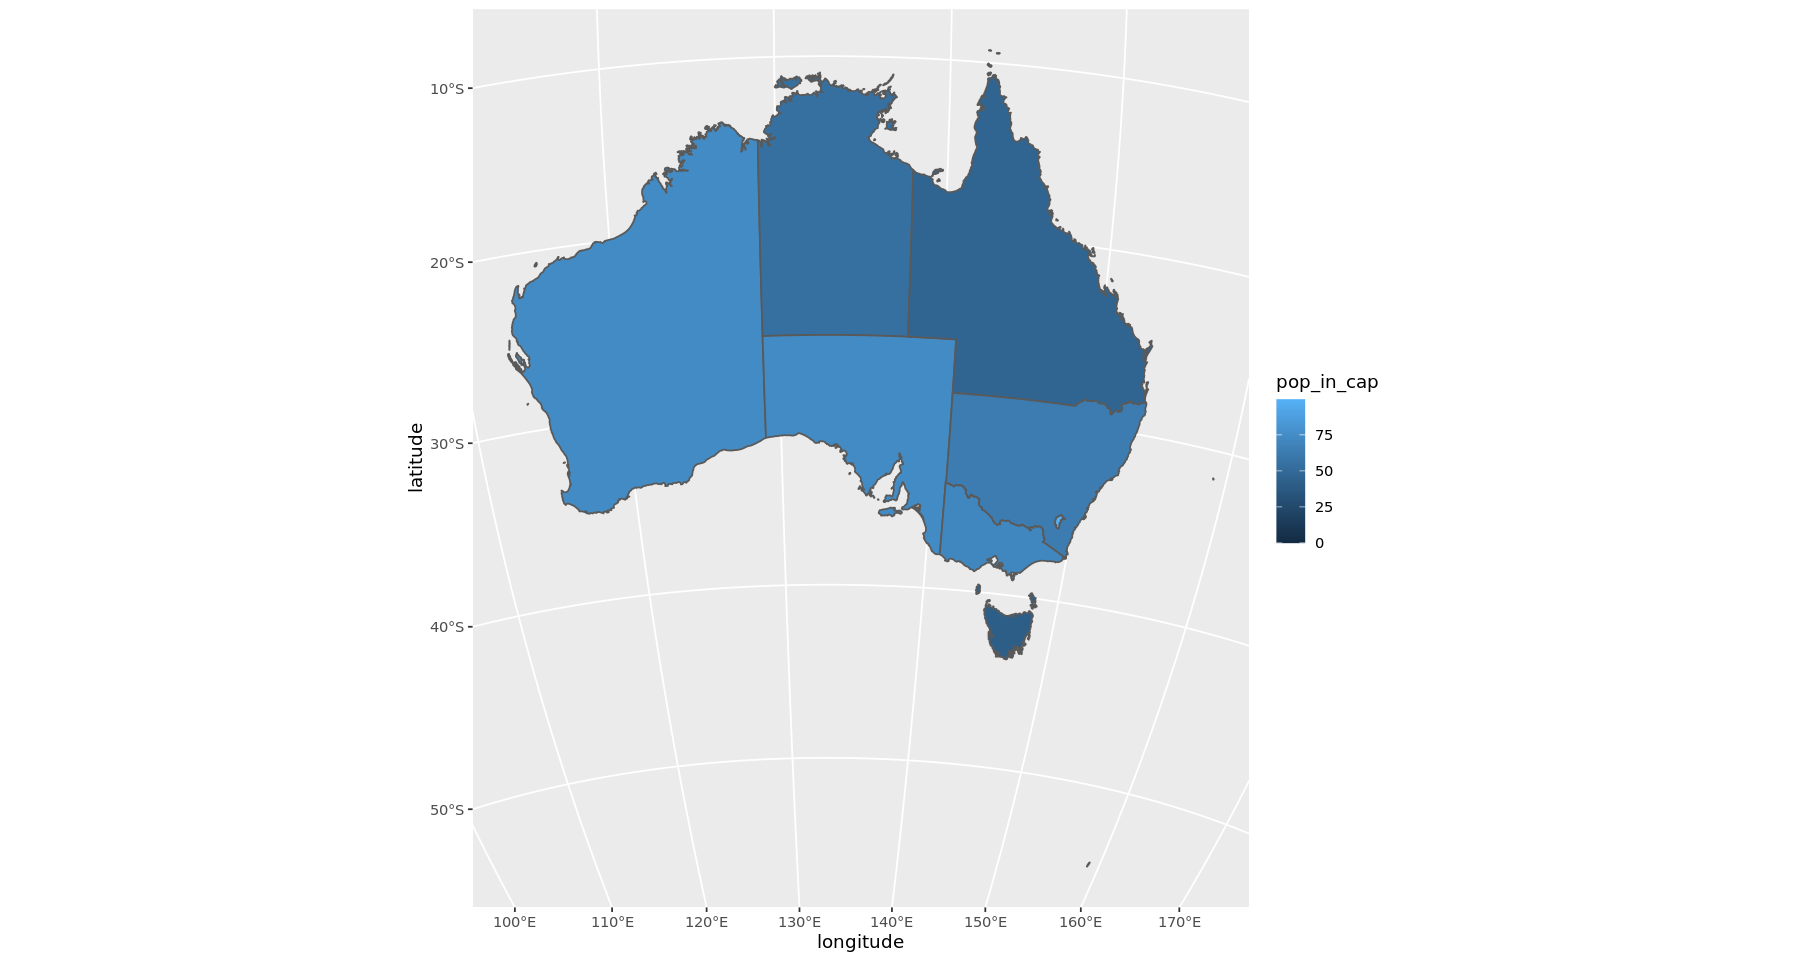

In [230]:
australia <-  ggplot() +
    geom_sf(data = in_sf, aes(fill = pop_in_cap)) +
  geom_label_repel(data = in_sf_label, 
                   aes(x=longitude,y = latitude, label = name),
                   size = 3, force = 5, force_pull = 5) + 
  coord_sf( crs= "+proj=ortho  +lat_0=-30 +lon_0=133")
australia

# Nothing too special here, orthographic like above and 
# The lat long settings are basically centring on the middle of 
# the nation 


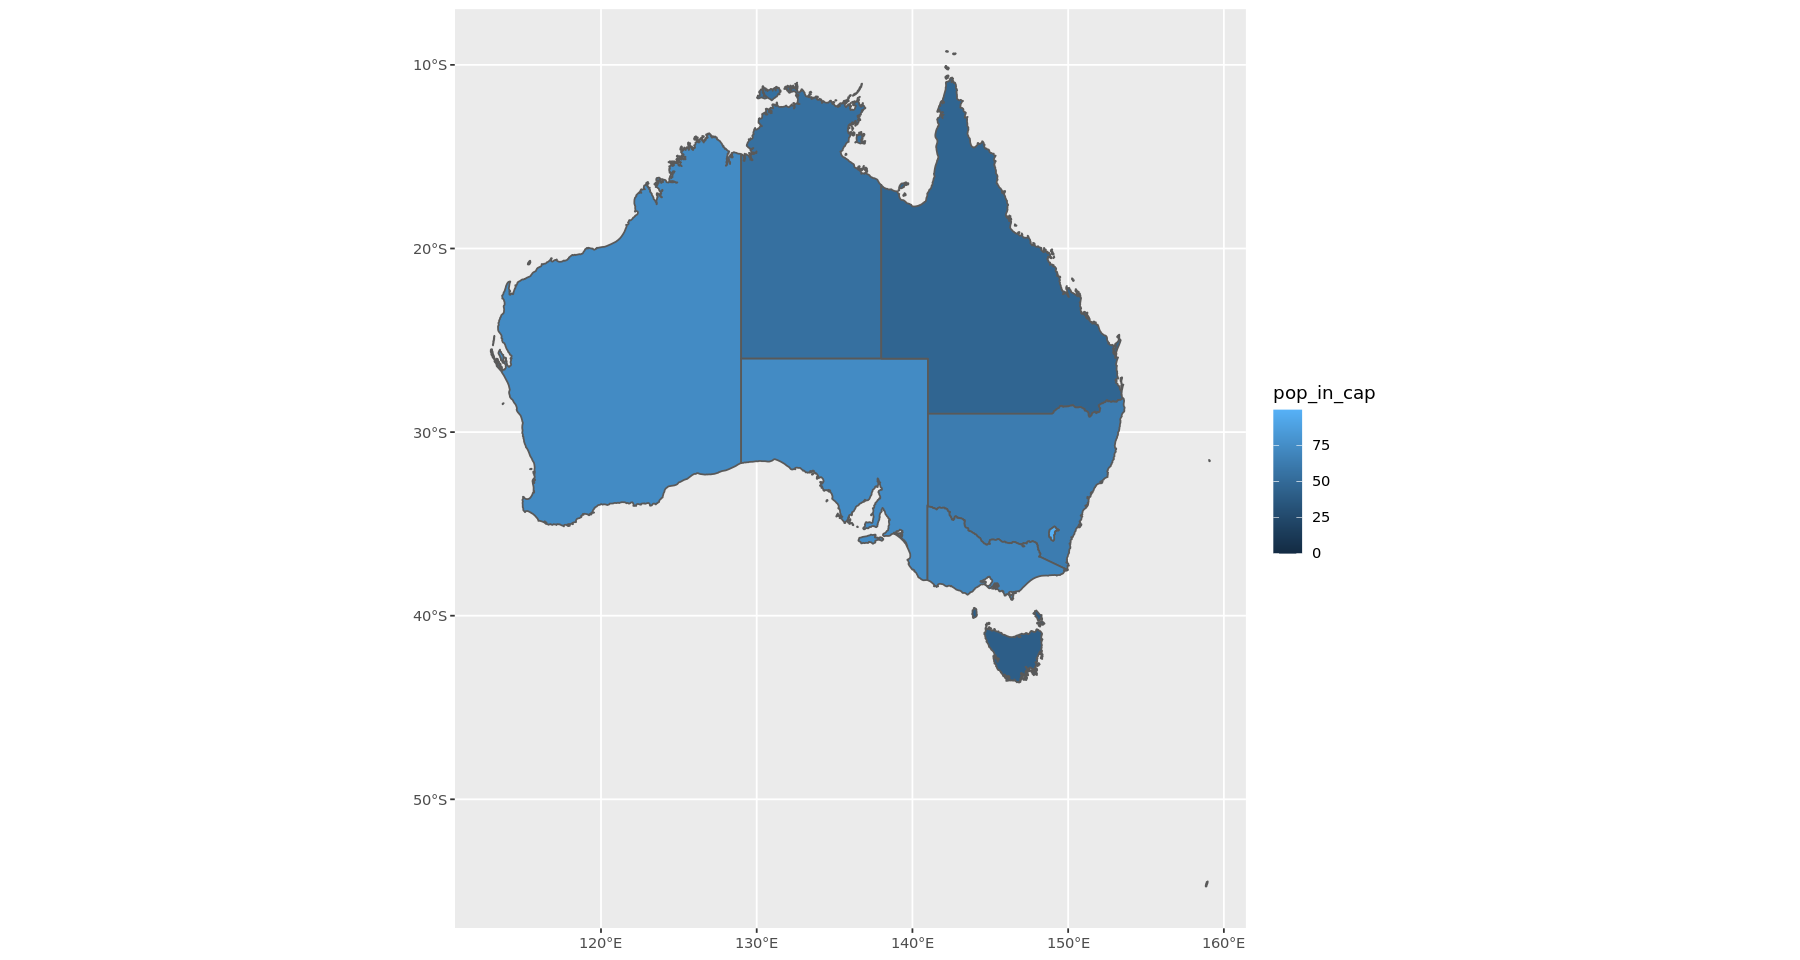

In [231]:
australia <-  ggplot() +
    geom_sf(data = in_sf, aes(fill = pop_in_cap)) + 
  coord_sf( crs= "+proj=latlong  +lat_0=-30 +lon_0=133") 
australia
 # The same thing with a normal (flat) conversion of lat and long

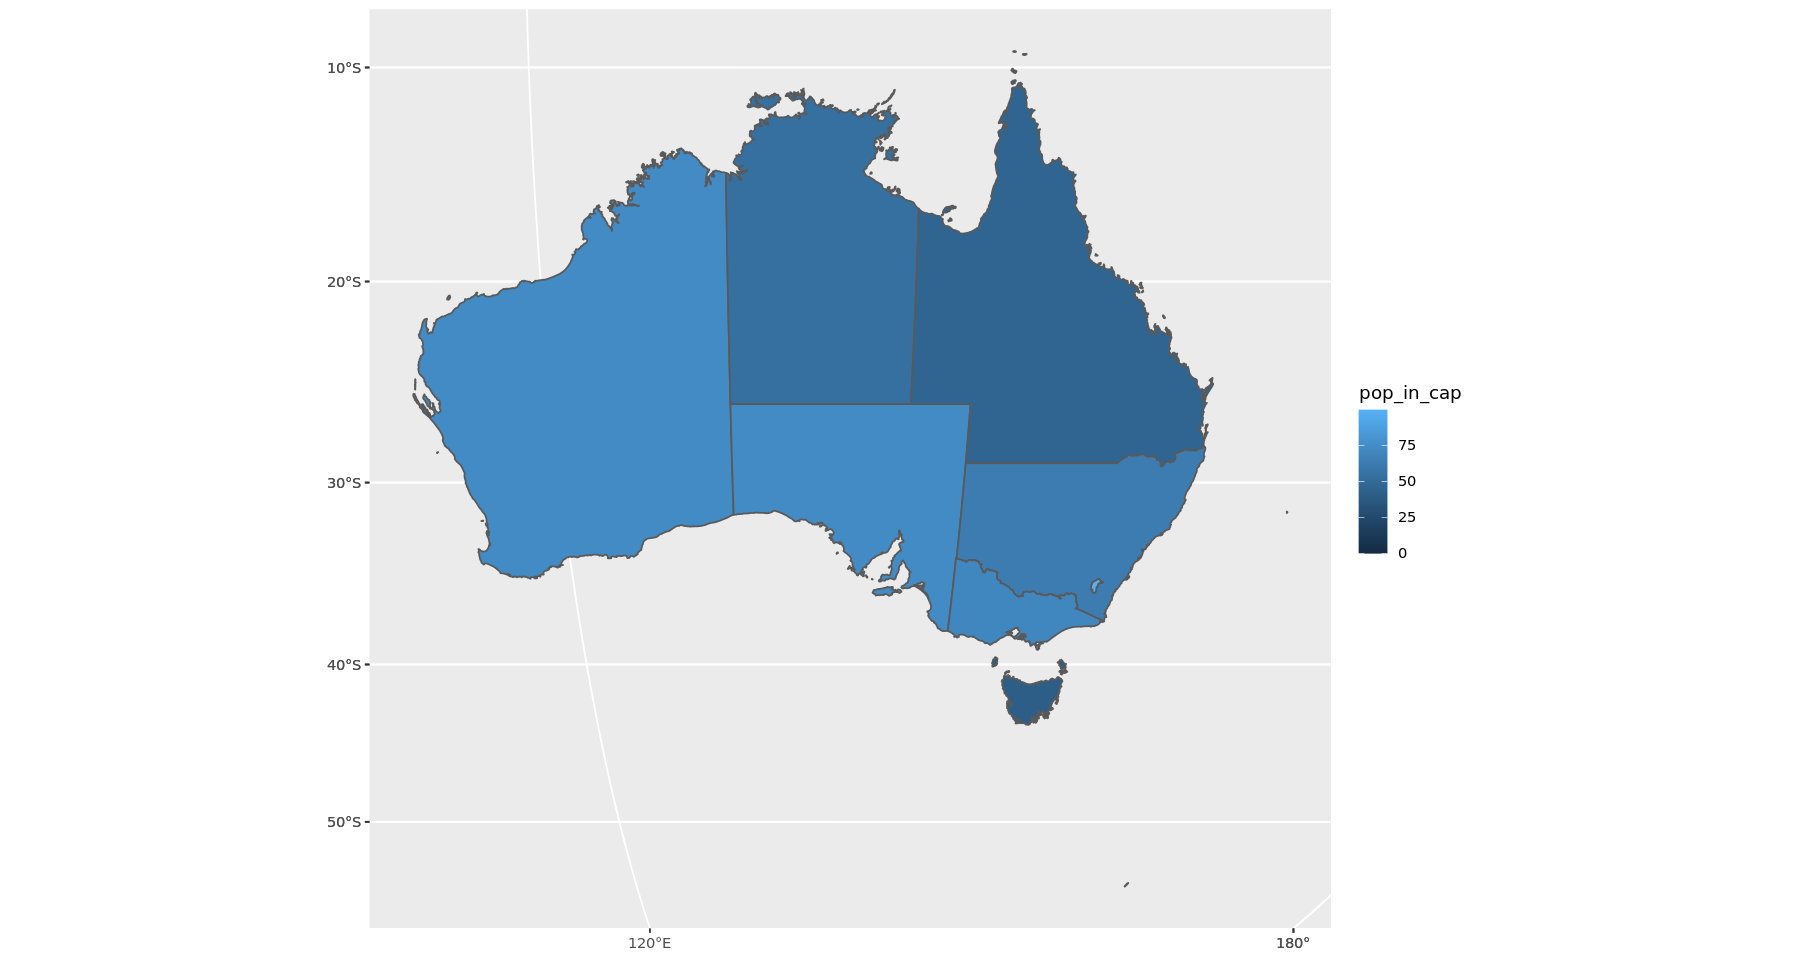

In [232]:
australia <-  ggplot() +
    geom_sf(data = in_sf, aes(fill = pop_in_cap)) + 
  coord_sf( crs= "+init=epsg:3577 +proj=ortho +ellps=GRS80
+datum=GGRS87") 
australia
 # epsg:3577 orthographic projection and an Ellipsoid 

Here are all the parameters you can feed through the proj string

| Param   | Description                                      |
|---------|--------------------------------------------------|
| +a      | Semimajor radius of the ellipsoid   axis         |
| +b      | Semiminor radius of the ellipsoid axis           |
| +datum  | Datum name                                       |
| +ellps  | Ellipsoid name                                   |
| +lat_0  | Latitude of origin                               |
| +lat_1  | Latitude of first standard parallel              |
| +lat_2  | Latitude of second standard parallel             |
| +lat_ts | Latitude of true scale                           |
| +lon_0  | Central meridian                                 |
| +over   | Allow longitude output outside -180 to 180 range |
| +proj   | Projection name                                  |
| +south  | Denotes southern hemisphere UTM zone             |
| +units  | meters                                           |
| +x_0    | False easting                                    |
| +y_0    | False northing                                   |
| +zone   | UTM zone                                         |

# Adding labels and annotations
Let's use the weird map projection from before and try to pin some Cities on the map. 

It's not clearly explained in a lot of tutorials how to do this. Usually they do not apply any projection - the map is a flat mercator map - and if that is the case you can just feed in the lat/lon as X, Y co-ords and everything works out (like the first map I made). 

When we do work with projections, when we specify a set of co-ordinates we also need to specify what projection those co-ordinates are based on. After playing around with it for a while, it seems that is it best to ALWAYS be explicit about the projection settings, which means that when you import or create any set of co-ordinates to put on a map you should also specify the `crs`. 

I have rationalised it as such; If I tell you that Brisbane's longitude is 153.0260, what is that in reference to? For instance, where is 0* in this case? We usually mean Grenwich is 0 but that is not always the case, and when ever we use projections in R all those assumptions are thrown out the window. I will try to illustrate that below:





In [233]:
label_frame <- data.frame("Label" = c("Brisbane", "Perth"), "Lat" = c(-27.4705, -31.9523), "Lon" = c(153.0260, 115.8613))
# I have created a crude dataframe of two city locations

label_frame <- st_as_sf(x=label_frame, coords = c("Lon", "Lat"), crs = "EPSG:4326")
# The st_as_sf takes our raw co-ord numbers and converts it into a geometry point.
# this not only has our lat / long info, but also the project info. (crs)
# Because these are `normal` lat/longs I have used a standard EPSG specification
# which is "WGS 84 -- WGS84 - World Geodetic System 1984, used in GPS". 
# A `normal` map; Grenwich is 0 etc. etc. 

# To check everything is ok, we can use st_is_longlat to check if it is the correct format
# Sometimes if the crs is invalid, it will silently fail and keep lon/lat the same, 
# you then run into problems when you try to plot the values. 
st_is_longlat(label_frame)


# Let's see what this looks like beforehand
label_frame$geometry

# You can see that the geometry information is still recognisable as a `normal` lat/long

# This is our weird projection from above. 
this_crs = "+init=epsg:3577 +proj=ortho +ellps=GRS80
+datum=GGRS87"

# We use st_transform to convert the co-ordinates into our weird projection 
st_transform(label_frame, this_crs)

# The x, y coords are now totally different, e.g. brisbanes co-ords 
# go from POINT (153.026 -27.4705) to POINT (2031772 -2924851)


[1] TRUE

POINT (153.026 -27.4705)

POINT (115.8613 -31.9523)



Geometry set for 2 features 
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: 115.8613 ymin: -31.9523 xmax: 153.026 ymax: -27.4705
Geodetic CRS:  WGS 84

,Label,geometry
,<chr>,<POINT [m]>
1,Brisbane,POINT (2031772 -2924851)
2,Perth,POINT (-1505788 -3356192)


In practice we don't need to do the `st_transform` ourselves, when doing the plotting. `coord_sf` will apply the transformations to every layer in the ggplot. All we need to be carefule about 
is making sure that the data points we give are in the correct format, and have a projection 
specified. See the example below. 
 







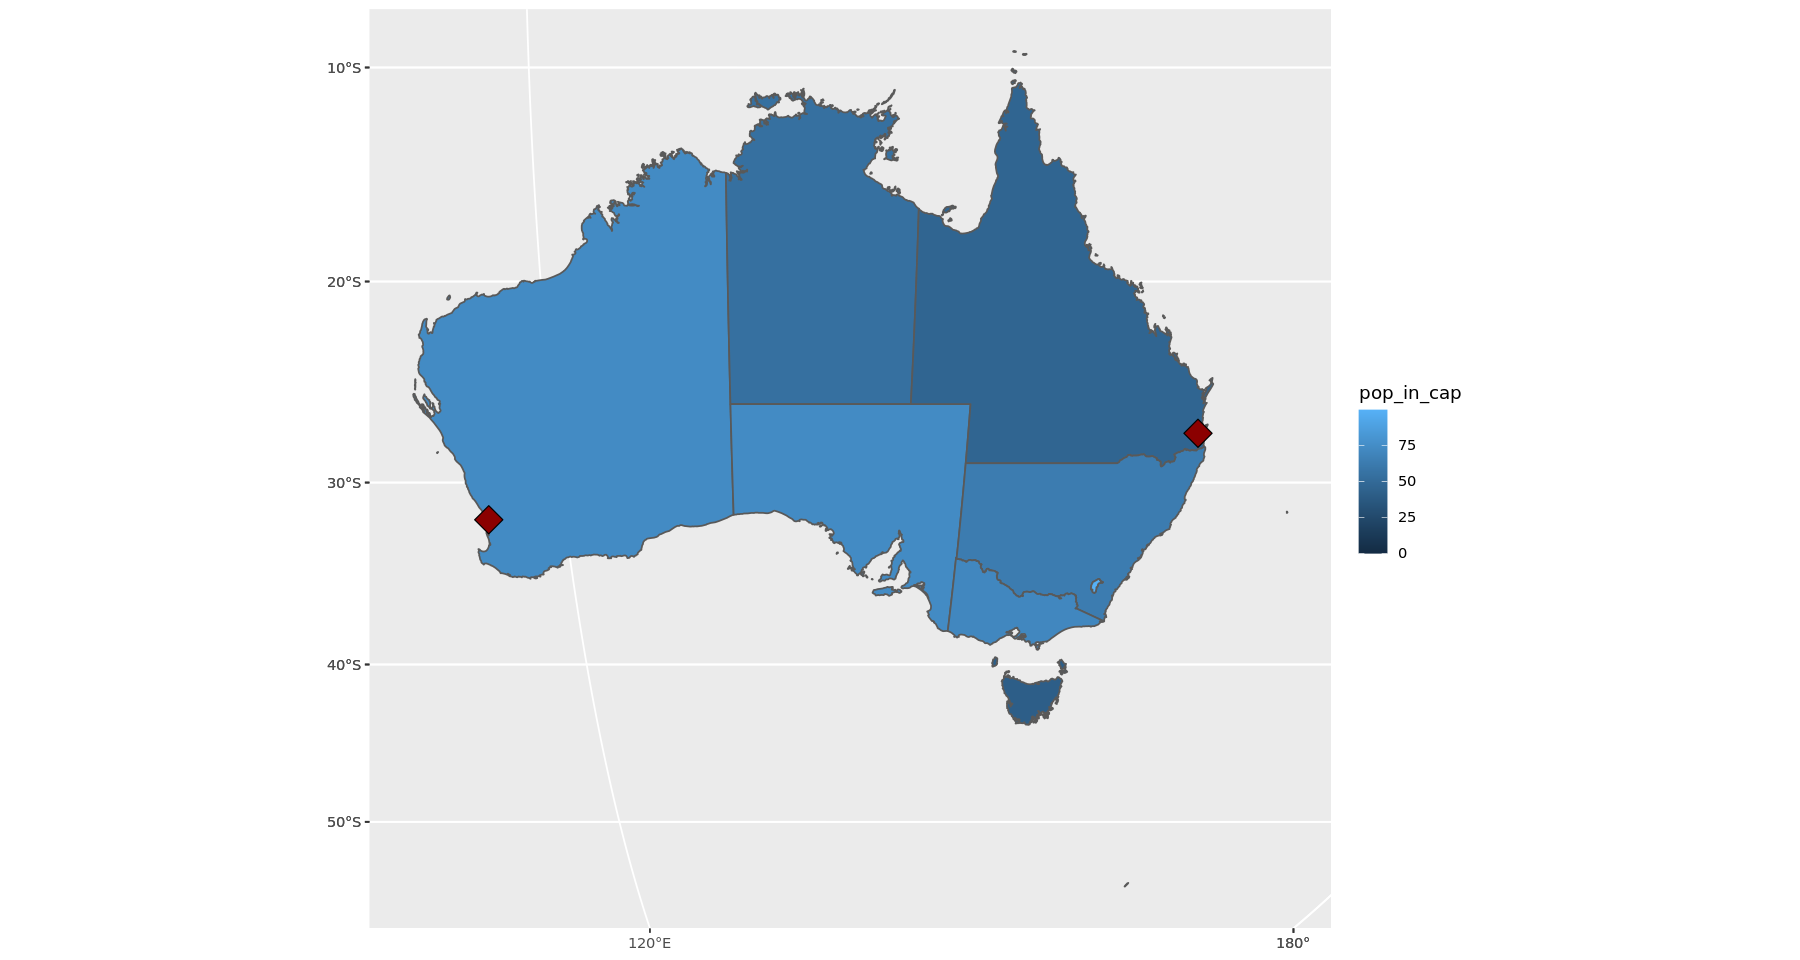

In [234]:
this_crs = "+init=epsg:3577 +proj=ortho +ellps=GRS80
+datum=GGRS87"

label_frame <- data.frame("Label" = c("Brisbane", "Perth"), "Lat" = c(-27.4705, -31.9523), "Lon" = c(153.0260, 115.8613))

label_frame <- st_as_sf(x=label_frame, coords = c("Lon", "Lat"), crs = "EPSG:4326")

# Again we create the dataframe and convert it to the correct geometry object - as above
# Now we plot, I am using the labels are red diamonds on the map. 
# We can pass it through like normal, no need to transform. coord_sf applies to the 
# whole figure. 

australia <-  ggplot(data = in_sf) + 
    geom_sf(aes(fill = pop_in_cap)) +
    geom_sf(data = label_frame, size = 6, shape = 23, fill = "darkred") +     
    coord_sf(crs=this_crs) 
australia




## So what happens if we do it wrong? 
crs is required for st_as_sf, it will not work otherwise but let's say we give the correct lat long but give a weird crs. 


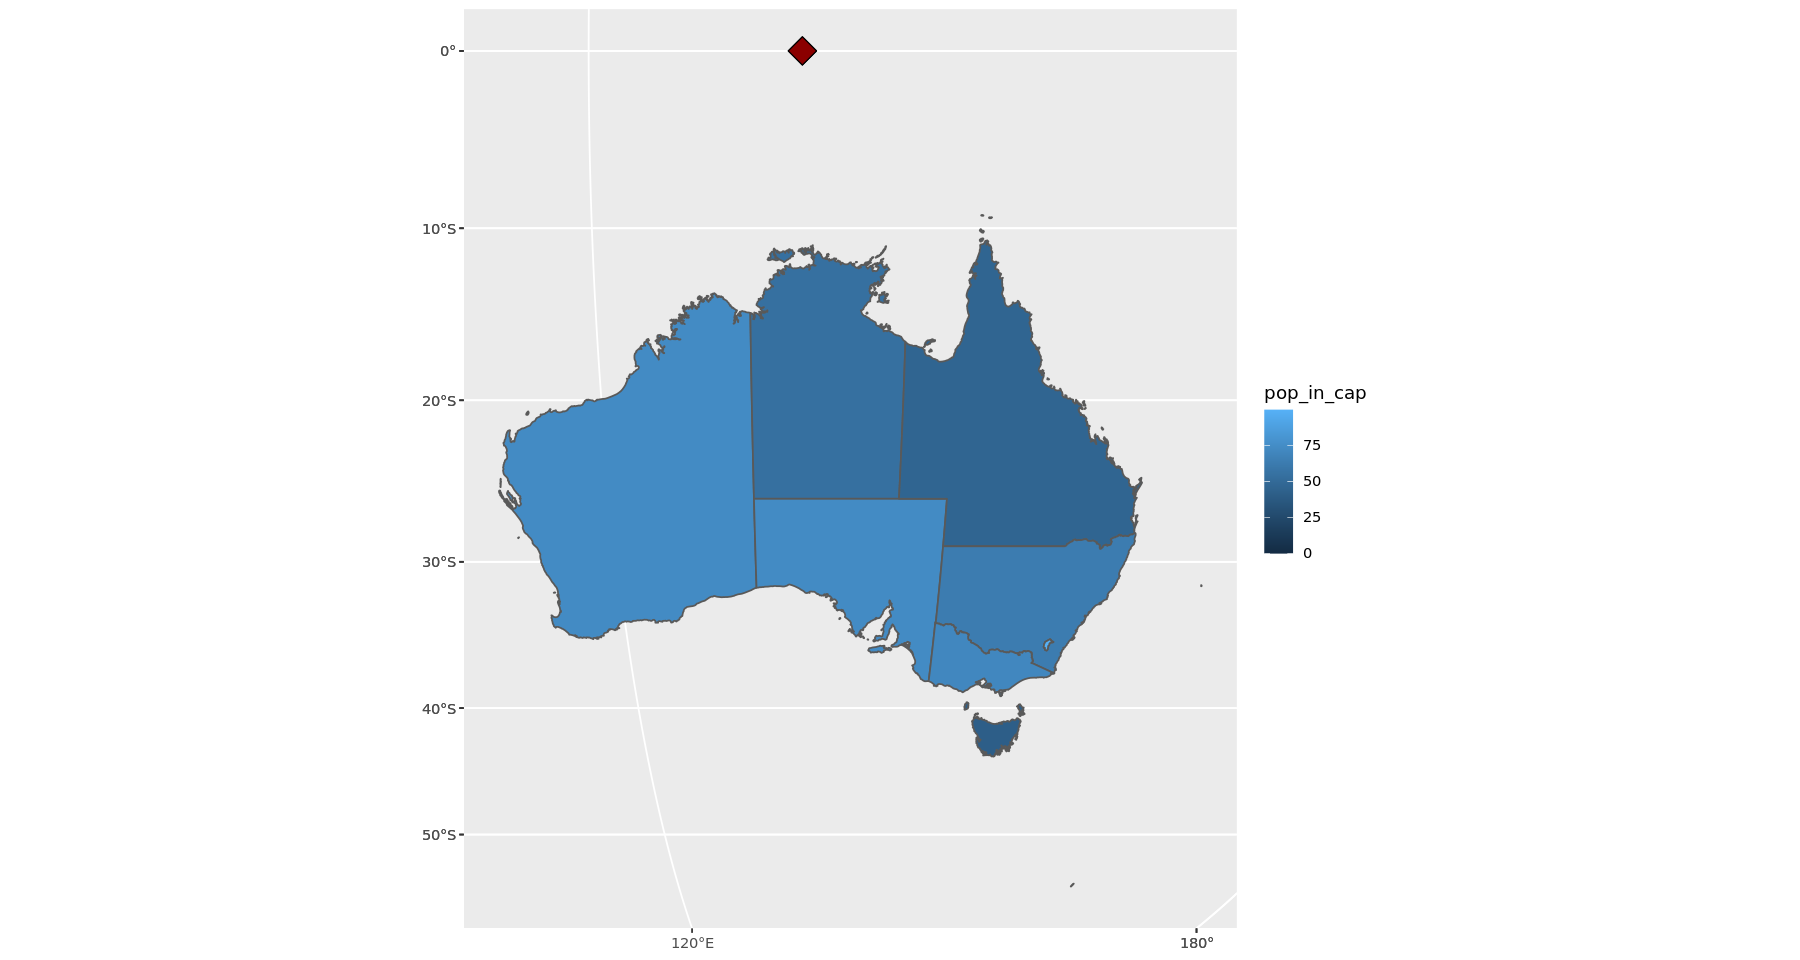

In [235]:
this_crs = "+init=epsg:3577 +proj=ortho +ellps=GRS80
+datum=GGRS87"

label_frame <- data.frame("Label" = c("Brisbane", "Perth"), "Lat" = c(-27.4705, -31.9523), "Lon" = c(153.0260, 115.8613))

label_frame <- st_as_sf(x=label_frame, coords = c("Lon", "Lat"), crs = this_crs)

australia <-  ggplot(data = in_sf) + 
    geom_sf(aes(fill = pop_in_cap)) +
    geom_sf(data = label_frame, size = 6, shape = 23, fill = "darkred") +     
    coord_sf(crs=this_crs) 
australia

Let's try this again, without the tranformation step and feeding it to geom_label_repel (exactly like we did in the map at the start).

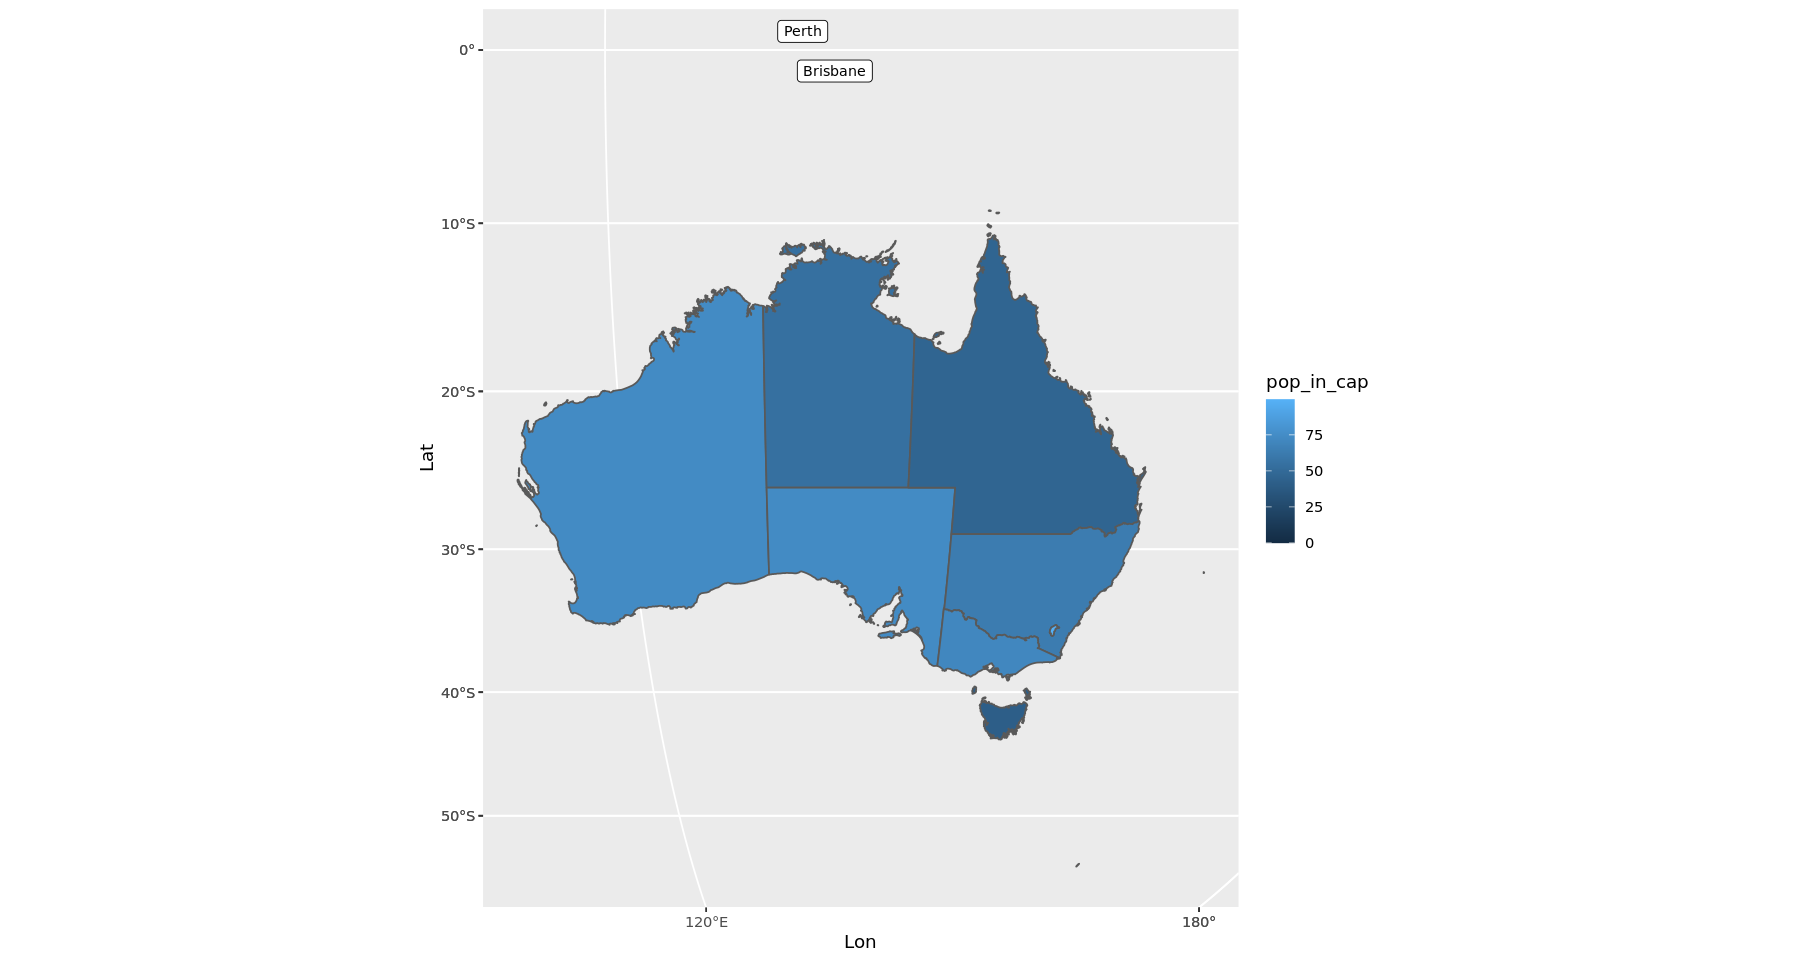

In [236]:
this_crs = "+init=epsg:3577 +proj=ortho +ellps=GRS80
+datum=GGRS87"

label_frame <- data.frame("Label" = c("Brisbane", "Perth"), "Lat" = c(-27.4705, -31.9523), "Lon" = c(153.0260, 115.8613))

australia <-  ggplot(data = in_sf) + 
    geom_sf(aes(fill = pop_in_cap)) +
      geom_label_repel(data = label_frame, 
                   aes(x=Lon,y = Lat, label = Label),
                   size = 3, force = 5, force_pull = 5) +
    coord_sf(crs=this_crs) 
australia

# The labels repel, but the placement is broken. 

A lot tutorials do not explain the transformation properly. They usually create their data from some other library or resource that has all the correct information baked in, so they often import the map, the data, make the plot and then apply the projection transform to the plot i.e. with `coord_sf` and everything works fine.

Let's do one example where the labels are correct. 


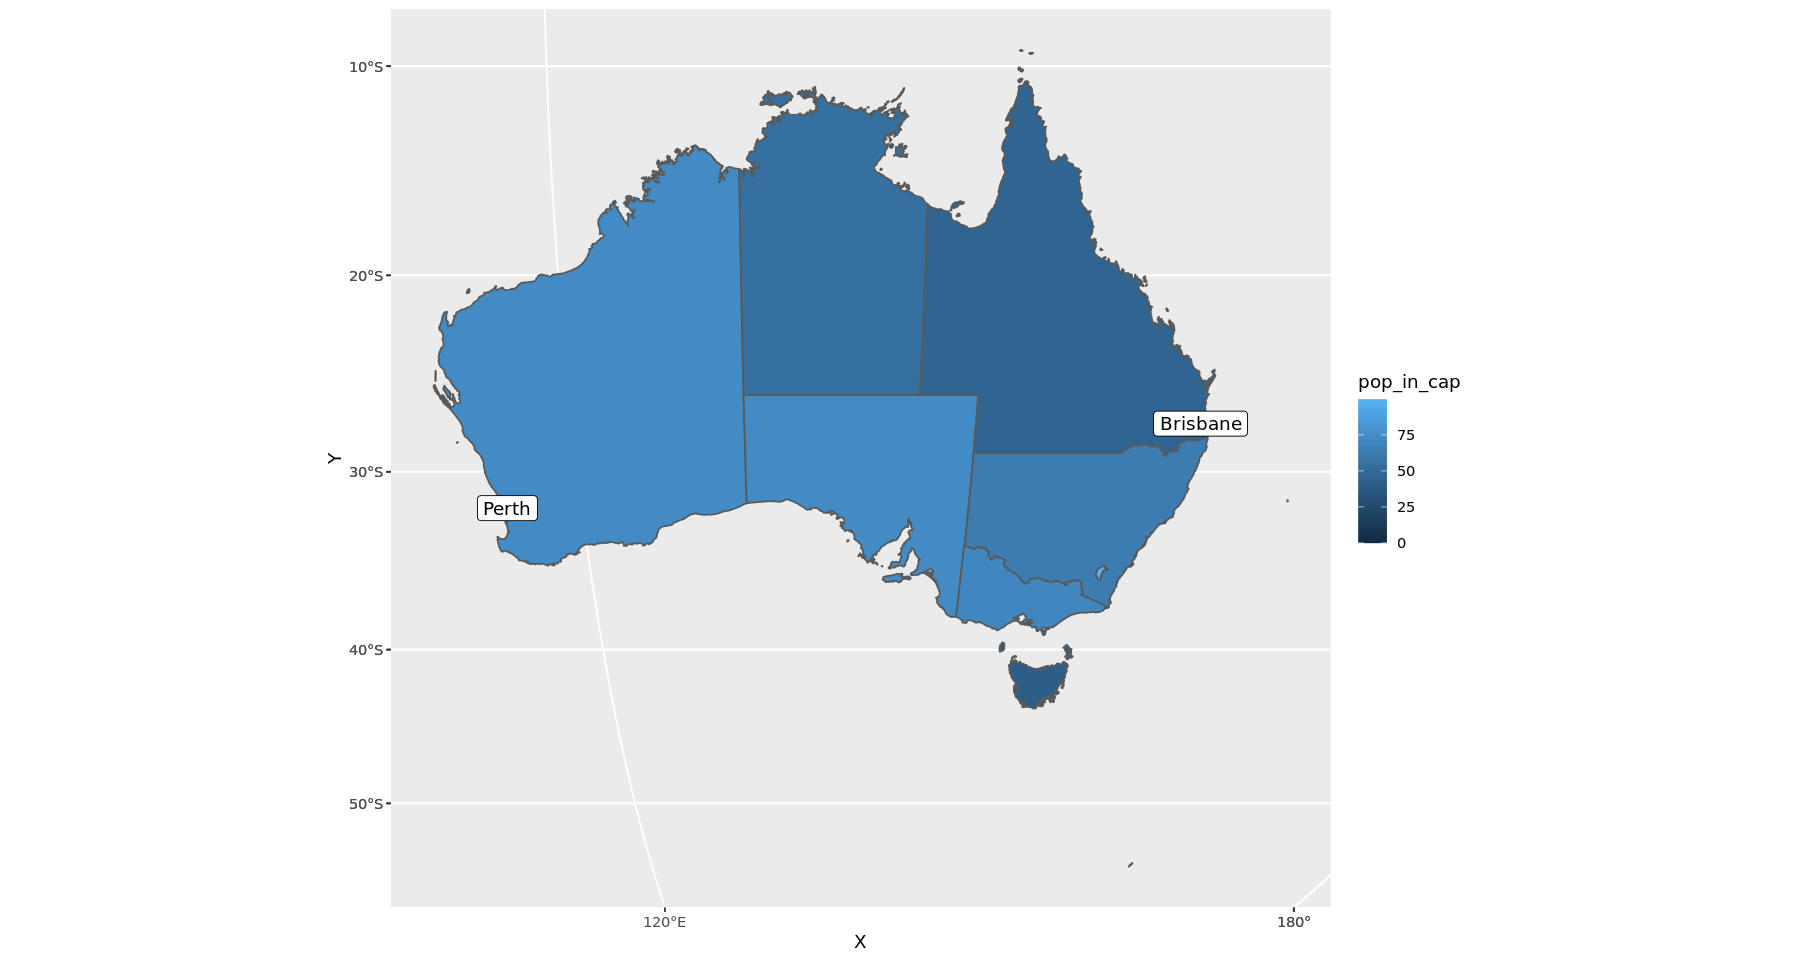

In [240]:
this_crs = "+init=epsg:3577 +proj=ortho +ellps=GRS80
+datum=GGRS87"

label_frame <- data.frame("Label" = c("Brisbane", "Perth"), "Lat" = c(-27.4705, -31.9523), "Lon" = c(153.0260, 115.8613))
label_frame <- st_as_sf(x=label_frame, coords = c("Lon", "Lat"), crs = "EPSG:4326")


australia <-  ggplot(data = in_sf) + 
    geom_sf(aes(fill = pop_in_cap)) +
    geom_sf_label(data = label_frame, aes(label = Label)) +     
    coord_sf(crs=this_crs) 
australia



## Adding repl labels 

`geom_sf_label` in the example above can be tranformed by `coord_sf`, which is why the labels show up in the correct place. But the labels will not automatically adjust themselves if your figure has many crowded labels. That's why I used `geom_label_repel` at the start  -- but `geom_label_repel` cant be transformed by coord_sf! 

So how can we have both? -- We have to use something else `geom_sf_label_repel` that will give us both features. 

The geom_sf_label_repel is in a separate library. Install using  `devtools::install_github("yutannihilation/ggsflabel")`

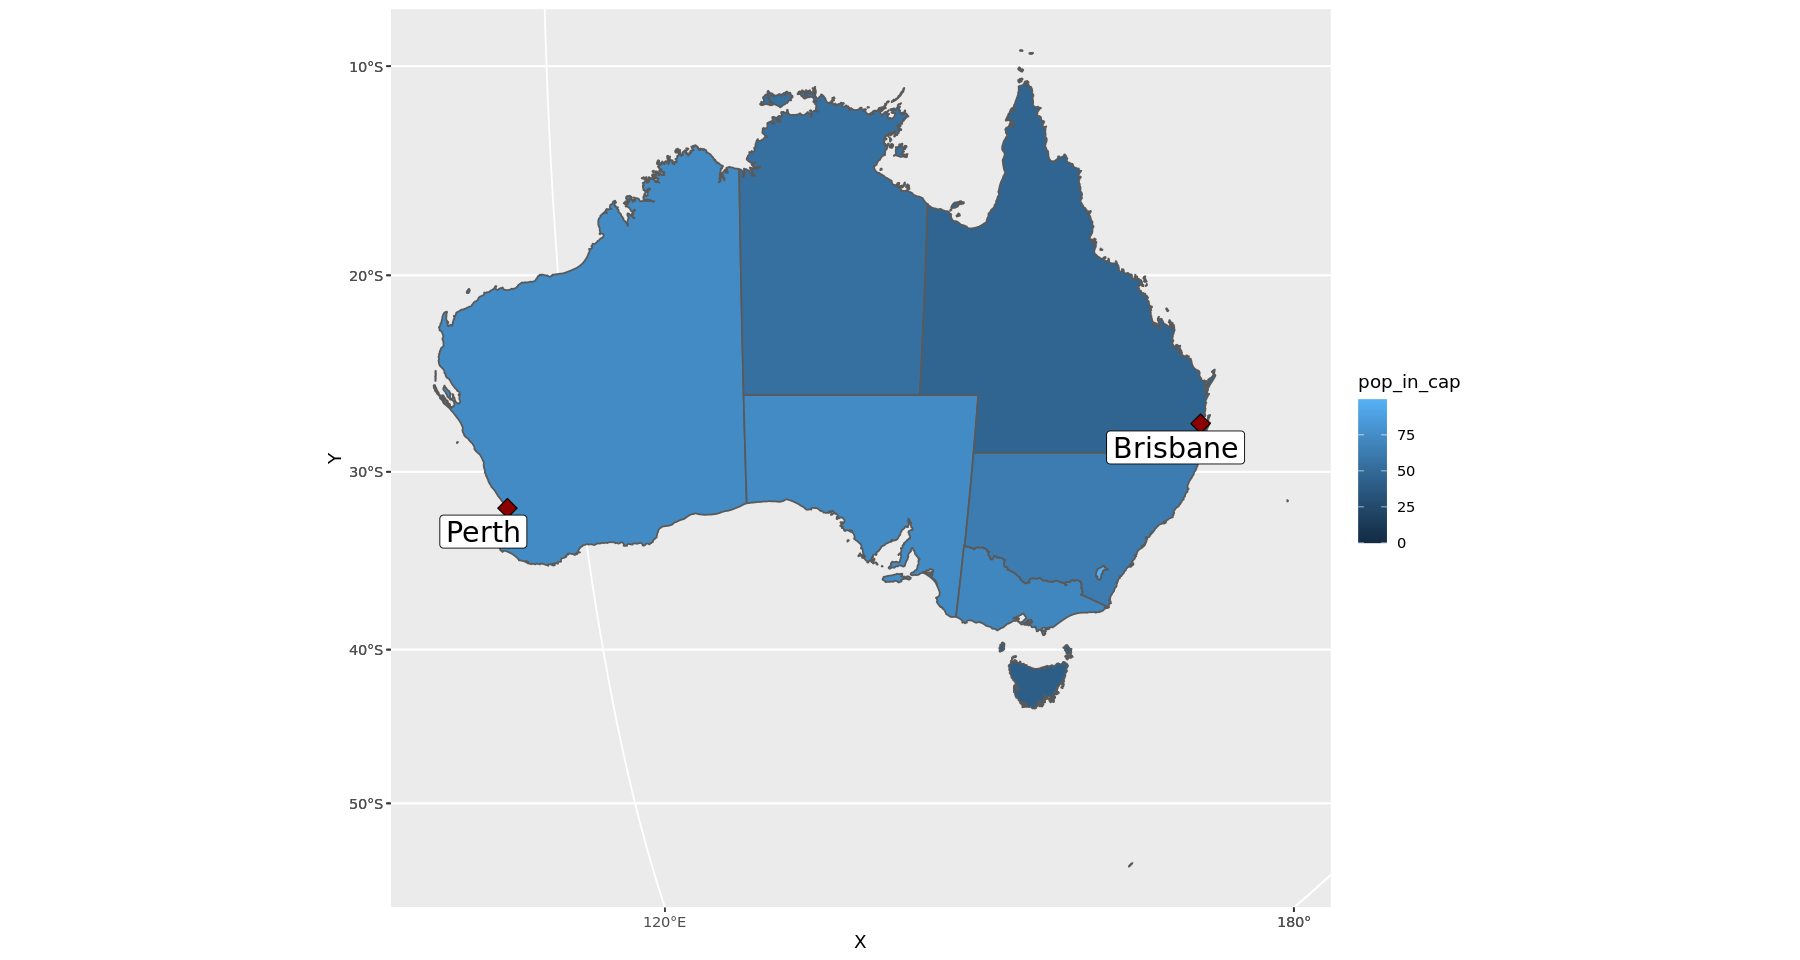

In [241]:
library(ggsflabel)

# The geom_sf_label_repel is in a seperate library 
# install using 
# devtools::install_github("yutannihilation/ggsflabel")

australia <-  ggplot(data = in_sf) + 
    geom_sf(aes(fill = pop_in_cap)) +
    geom_sf(data = label_frame, size = 4, shape = 23, fill = "darkred") + 
    geom_sf_label_repel(
        data = label_frame,
        aes(geometry = geometry, label = Label),
        size = 6, force = 5, force_pull = 5) +
    coord_sf(crs=this_crs) 
australia